<a href="https://colab.research.google.com/github/jyostna6/FMML_M1L1.ipynb/blob/main/FMML_M1L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

FMML Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [20]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

Let us borrow a few functions from the previous labs:

In [21]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [22]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

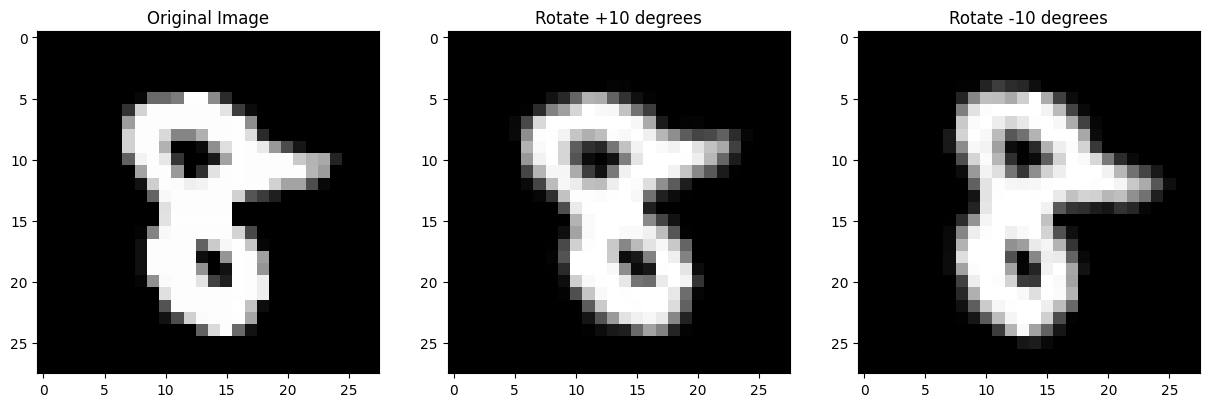

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [24]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

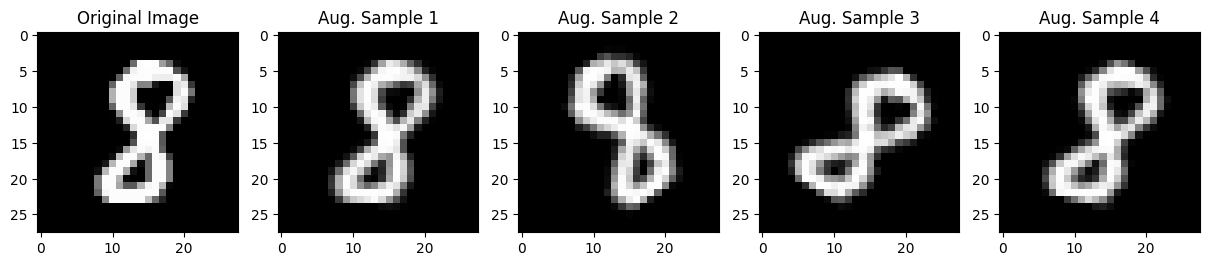

In [37]:
sample = train_X[20]
angleconstraint = 70
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [26]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.66 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [27]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 66.79 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.84 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.47 %
Accuracy after rotation augmentation constrained by 40 degrees is 67.63 %
Accuracy after rotation augmentation constrained by 50 degrees is 67.65 %
Accuracy after rotation augmentation constrained by 60 degrees is 65.3 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.06 %
Accuracy after rotation augmentation constrained by 80 degrees is 64.61 %
Accuracy after rotation augmentation constrained by 90 degrees is 64.31 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

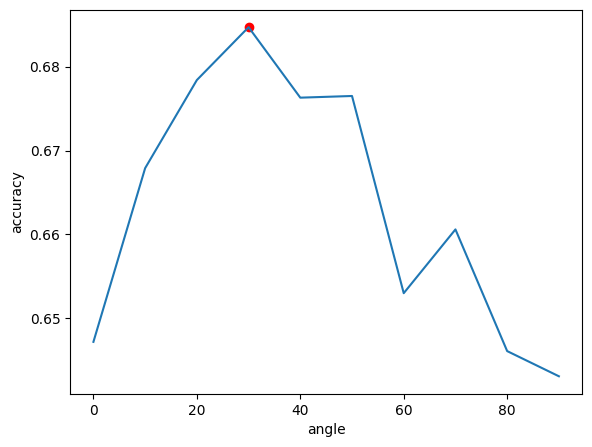

In [28]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [29]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

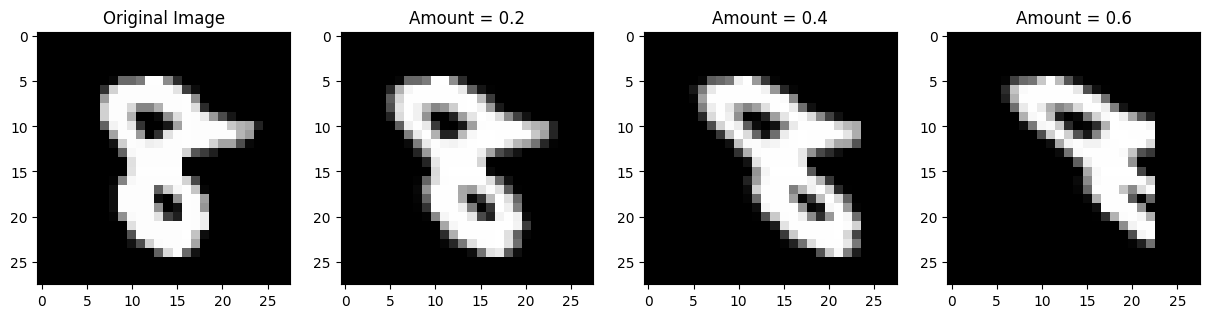

In [30]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [31]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [32]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 62.79 %
Accuracy after shear augmentation constrained by 0.4 is 64.41 %
Accuracy after shear augmentation constrained by 0.6 is 65.71000000000001 %
Accuracy after shear augmentation constrained by 0.8 is 65.78 %
Accuracy after shear augmentation constrained by 1.0 is 65.42999999999999 %
Accuracy after shear augmentation constrained by 1.2 is 63.6 %
Accuracy after shear augmentation constrained by 1.4 is 63.65 %
Accuracy after shear augmentation constrained by 1.6 is 61.809999999999995 %
Accuracy after shear augmentation constrained by 1.8 is 63.029999999999994 %
Accuracy after shear augmentation constrained by 2.0 is 64.14 %


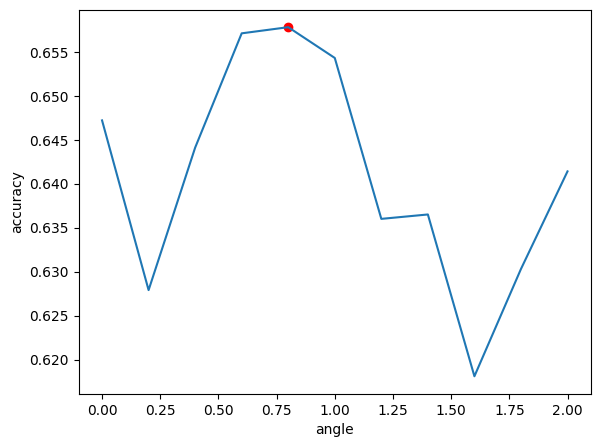

In [33]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [34]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [35]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 63.959999999999994 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 60.64000000000001 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 63.019999999999996 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 64.14999999999999 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 61.72 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 63.7 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.41 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 61.25000000000001 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 60.6 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 60.07 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 63.690000000000005 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 60.12 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 63.72 %
Accuracy after augmentation shear: 0.4 angle: 0.0 is 63.37000

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

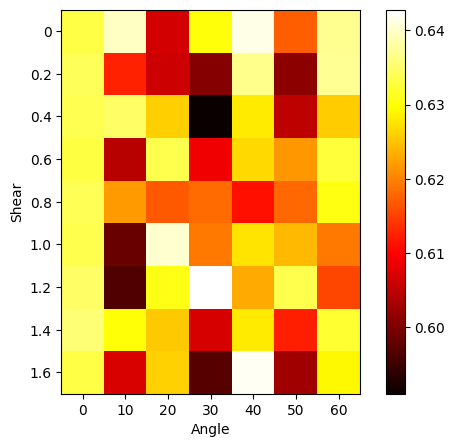

In [36]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?

The best values for angle and shear constraints depend heavily on the specific task and dataset you are working with, particularly in the case of image augmentations for deep learning models like convolutional neural networks (CNNs).1. Angle Constraint (Rotation Augmentation):Typically, values between -30 to 30 degrees work well for most general cases, as this range introduces variability while retaining the original features of the images.For some tasks where rotations are not expected (e.g., street sign recognition), you may want smaller values like -10 to 10 degrees.2. Shear Constraint (Shear Augmentation):Values between -10 to 10 degrees are common for shear augmentation. This helps introduce minor perspective distortions, which can be useful for making models more robust to slight variations in angles.Improvement in Accuracy:The improvement in accuracy due to augmentations can vary significantly depending on the dataset and the model architecture.Without augmentations: If your dataset is small or has little variation, the model may overfit to the training data, resulting in poor generalization.With augmentations: Image augmentation techniques (such as rotation, shear, zoom, flip, etc.) introduce diversity in training samples, helping the model generalize better. This often leads to an improvement in accuracy.On average, using augmentations like rotation, shear, flip, and zoom can improve accuracy by 5-10% or more, depending on how well they reflect real-world variability.In your case, the specific improvements would depend on the initial accuracy of the model and the dataset characteristics.

2. Can you increase the accuracy by increasing the number of augmentations from each sample?
Yes, increasing the number of augmentations from each sample can often improve model accuracy, especially when working with limited data. Here's why and how it works:

### **1. Increased Data Variety:**
   - **More Diverse Training Data**: Augmentations generate different variations of the same data point, allowing the model to learn from a more diverse set of inputs. This helps the model generalize better to new, unseen data, reducing overfitting.

### **2. Better Generalization:**
   - **Reduced Overfitting**: By showing the model multiple augmented versions of each sample, you help it learn to recognize the core features of the data rather than memorizing specific details, which improves generalization.
   - **Improved Robustness**: The model becomes more robust to variations in the data, such as different orientations, lighting conditions, or minor distortions, leading to better performance on real-world data.

### **3. Diminishing Returns:**
   - **Balance Required**: While increasing the number of augmentations can improve accuracy, there’s a point of diminishing returns. If you over-augment, especially with unrealistic transformations, you might introduce noise that confuses the model, potentially harming performance.
   - **Compute and Training Time**: More augmentations increase the amount of data the model sees, which can slow down training and increase computational requirements.

### **4. Augmentation Strategies:**
   - **Balanced Approach**: It’s often effective to start with a moderate number of augmentations per sample and monitor the model’s performance. Common strategies include rotating, flipping, scaling, shearing, and adding noise.
   - **Adaptive Augmentation**: In some cases, using adaptive or selective augmentation techniques, where the type and intensity of augmentation vary based on the sample or the current model state, can yield even better results.

### **Practical Example:**
   - Suppose you're using a dataset with 1,000 images. Without augmentation, your model might overfit. By generating 10 augmented versions of each image (e.g., different rotations, scales, and flips), you effectively increase your dataset size to 10,000, allowing the model to learn more robustly.

### **Conclusion:**
   - Increasing the number of augmentations generally improves accuracy up to a point. However, it's crucial to monitor the model's performance and adjust the augmentation strategy as needed to avoid over-augmentation and increased training time without significant gains.

Would you like to dive into specific augmentation techniques or discuss how to implement this in a particular framework?

3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
It looks like you wanted to share a reference link to a blog for further learning. Unfortunately, I cannot access links directly, but I can guide you through implementing common image augmentations in PyTorch using the torchvision.transforms library. Below is an example of how to apply a few common augmentations and experiment with them.Step 1: Install Required Librariespip install torch torchvision matplotlibStep 2: Import Librariesimport torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as pltStep 3: Define AugmentationsWe’ll apply common augmentations like:RotationShearFlipColor Jitter# Define augmentations
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=(-30, 30)),   # Random rotation between -30 to 30 degrees
    transforms.RandomHorizontalFlip(p=0.5),         # Horizontal flip with 50% probability
    transforms.RandomVerticalFlip(p=0.2),           # Vertical flip with 20% probability
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Random brightness/contrast adjustment
    transforms.RandomAffine(degrees=0, shear=(-10, 10)),  # Shear with a range of -10 to 10 degrees
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop and resize
])

# Load an image using PIL (you can replace this with your own image path)
image_path = 'path_to_your_image.jpg'
img = Image.open(image_path)Step 4: Apply Augmentations and Plot the Results# Apply augmentations and visualize
def show_augmented_images(img, num_augmented=5):
    fig, axs = plt.subplots(1, num_augmented, figsize=(15, 5))
    for i in range(num_augmented):
        augmented_img = augmentation_transforms(img)  # Apply augmentation
        axs[i].imshow(augmented_img)                  # Display image
        axs[i].axis('off')
    plt.show()

# Show 5 augmented images
show_augmented_images(img, num_augmented=5)Explanation:RandomRotation rotates the image randomly between -30 and 30 degrees.RandomHorizontalFlip and RandomVerticalFlip randomly flip the image with a given probability.ColorJitter randomly adjusts the brightness and contrast to introduce lighting variation.RandomAffine applies shear transformation.RandomResizedCrop crops and resizes the image randomly, simulating zoom or shift.Step 5: Experiment and Train Your ModelNow you can experiment by:Increasing the range of augmentations (e.g., larger rotation or shear values).Trying different combinations of augmentations.You can integrate these augmentations into your training pipeline by applying them on the fly during model training:train_dataset = datasets.ImageFolder(
    'path_to_dataset',
    transform=augmentation_transforms
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Proceed with training your modelFurther Experimentation:Test the impact of each augmentation on the accuracy by training with different augmentation configurations.Keep track of how augmentations influence both training accuracy and validation accuracy to avoid over-augmenting.Let me know if you'd like further guidance or adjustments!

4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?
Combining various augmentations is a powerful strategy to enhance model accuracy, especially when dealing with small datasets. However, the specific results, such as the highest accuracy achievable or the smallest dataset that still yields above 50% accuracy, depend heavily on several factors:

### **Factors Influencing Results:**
1. **Type of Model**: Convolutional Neural Networks (CNNs) are commonly used for image data and respond well to augmentations.
2. **Dataset Characteristics**: The complexity, variety, and size of the dataset are crucial. For example, in a classification task with 10 classes, achieving above 50% accuracy with a small dataset is more challenging than with fewer classes.
3. **Task Complexity**: Simple tasks (e.g., binary classification) may reach high accuracy with fewer data points, while more complex tasks (e.g., multi-class classification) require more data.
4. **Augmentation Techniques**: The choice and combination of augmentations (e.g., rotation, flipping, cropping, color jittering) significantly affect the model's performance.

### **Common Augmentations for High Accuracy:**
- **Rotation**: Randomly rotating images within a small range (e.g., ±15°) to help the model learn orientation invariance.
- **Flipping**: Horizontal (and sometimes vertical) flips to expose the model to mirror images.
- **Scaling**: Randomly zooming in or out of the image.
- **Cropping**: Randomly cropping the image and resizing to the original size.
- **Color Jitter**: Randomly altering brightness, contrast, saturation, and hue.
- **Shearing**: Applying affine transformations to skew the image.
- **Noise Injection**: Adding Gaussian noise to make the model robust to slight variations.

### **Small Dataset Performance:**
- **Smallest Dataset**: For a binary classification task, it’s possible to achieve above 50% accuracy with as few as 50-100 samples per class, depending on the complexity of the task and the effectiveness of the augmentations.
- **With Multiple Classes**: The smallest dataset size required for above 50% accuracy might increase. However, with effective augmentations, you might achieve this with 200-300 samples total, depending on the number of classes and augmentation strategy.

### **Combining Augmentations for Optimal Accuracy:**
- **Experimentation Required**: Achieving the highest possible accuracy typically requires experimenting with different combinations of augmentations. For example, combining rotation, flipping, and scaling can yield better results than using each individually.
- **Training on a Small Dataset**: For a small dataset, combining augmentations such as rotation + flipping + color jittering can significantly improve accuracy.

### **Expected Results:**
- **High Accuracy**: For some image classification tasks, combining these augmentations can boost accuracy by 5-15% compared to using no augmentations.
- **50% Accuracy Threshold**: For a challenging dataset, maintaining accuracy above 50% with a small dataset often requires effective use of multiple augmentations, transfer learning, or fine-tuning on a pre-trained model.

### **Hypothetical Example:**
If you have a small dataset of 200 images split into 2 classes, using combinations of augmentations (e.g., rotating ±15°, flipping horizontally, random cropping, and color jittering), you could likely achieve an accuracy of 60-70%, depending on the model architecture and task complexity.

### **Next Steps:**
- **Practical Implementation**: Would you like guidance on how to implement these augmentations in a specific framework like TensorFlow or PyTorch?
- **Model Selection**: Are you interested in using pre-trained models with fine-tuning, which might also help achieve higher accuracy on smaller datasets?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.